In [31]:
%load_ext autoreload 
%autoreload 2
import apache_beam   # Needs to be imported separately to avoid TypingError
import weatherbench2
from weatherbench2 import config
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2.metrics import MSE, SpatialMSE
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import colormaps as cmaps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
plt.rcParams['font.stretch'] = 'condensed'
plt.rcParams['figure.dpi'] = 200 
plt.rcParams['savefig.dpi'] = 200

import numpy as np
from typing import Tuple
import matplotlib.colors as mcolors

import os
os.chdir('/home/meyerstj/bin/weatherbench2/notebooks/')

import dask

from dask.distributed import Client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# client = Client(n_workers = 15, threads_per_worker = 1)

In [91]:
forecast_dict = dict(
    panguweather = dict(forecast_path = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'),
    ifs = dict(forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'),
    graphcast = dict(forecast_path = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'),
)
obs_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
time_slice = slice('2020-01-01', '2020-12-31')
variables=['mean_sea_level_pressure', '10m_wind_speed']

In [94]:
for model in forecast_dict.keys():
    print(f'{model} has ')
    
    ds = xr.open_zarr(forecast_dict[model]['forecast_path']).sel(time = time_slice)
    n_inits  = len(ds.time)
    
    print(f'{n_inits} inits')

panguweather has 
732 inits
ifs has 
732 inits
graphcast has 
732 inits


In [68]:
selection = config.Selection(
    variables= variables,
    time_slice=time_slice,
)
regions = {
    'Aotearoa': SliceRegion(lat_slice=slice(-55, -33), lon_slice = slice (165,180))
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'spatial_mse': SpatialMSE()
      },
      regions=regions
  )
}

In [72]:
# %%time
# for model in forecast_dict.keys():
forecast_path = forecast_dict[model]['forecast_path']
opath = model

paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir=opath,   # Directory to save evaluation results
)

data_config = config.Data(selection=selection, paths=paths, rename_variables={'lat':'latitude','lon':'longitude'})
evaluate_in_memory(data_config, eval_configs)

In [70]:
model


'graphcast'

In [51]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'

climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_1440x721.zarr'
forecast_path_ifs ='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
forecast_path_pgw ='gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
forecast_path_grf ='gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'


In [55]:
time_slice = slice('2020-01-01', None)
variables=['mean_sea_level_pressure', '10m_wind_speed']

In [34]:
paths = config.Paths(
    forecast=forecast_path_pgw,
    obs=obs_path,
    output_dir='panguweather/',   # Directory to save evaluation results
)

In [35]:
selection = config.Selection(
    variables= variables,
    time_slice=time_slice,
)

In [36]:
data_config = config.Data(selection=selection, paths=paths)

In [37]:


regions = {
    'Aotearoa': SliceRegion(lat_slice=slice(-55, -33), lon_slice = slice (165,180))
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'spatial_mse': SpatialMSE()
      },
      regions=regions
  )
}

In [38]:
%%time
evaluate_in_memory(data_config, eval_configs)

CPU times: user 5min 51s, sys: 1min 45s, total: 7min 36s
Wall time: 3min 32s


In [2]:
error_ifs = np.sqrt(xr.open_dataset('ifs/deterministic.nc'))
error_pgw = np.sqrt(xr.open_dataset('panguweather/deterministic.nc'))
error_gcs = np.sqrt(xr.open_dataset('graphcast//deterministic.nc'))

In [3]:
def subset(ds):
    return ds.sel(latitude = slice(-50, -25 ), longitude = slice(165, 185)).sel(metric = 'spatial_mse').mean('lead_time')


def subset_space(ds):
    return ds.sel(latitude = slice(-50, -25), longitude = slice(165, 185)).sel(metric = 'spatial_mse').mean(['latitude', 'longitude'], skipna = True)

In [4]:
diff_pgw = subset(error_ifs) - subset(error_pgw)
diff_gcs = subset(error_ifs) - subset(error_gcs)

In [5]:
subset_ifs = subset(error_ifs)
subset_pgw = subset(error_pgw)
subset_gcs = subset(error_gcs)

In [47]:

def set_gridlines(ax):
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 10))  # Longitude every 10 degrees
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))    # Latitude every 10 degrees
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Show labels only on the bottom and right sides
    gl.right_labels = True
    gl.left_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 8, 'color': 'black'}
    gl.ylabel_style = {'size': 8, 'color': 'black'}
    
def create_plot_kwargs(cmap : str, vmin : int, vmax : int, spacing : int) -> Tuple[dict,dict] :
    
    cmap = get_cmap(cmap)
   
    norm = mcolors.BoundaryNorm(boundaries=np.arange(vmin,vmax,spacing/2), ncolors=cmap.N, clip=False, extend = 'neither')
    
    plot_kw = {'transform' : ccrs.PlateCarree(),  'add_colorbar':False,  'cmap' : cmap,'alpha':0.8, 'levels':  np.arange(vmin,vmax,spacing/2), 'norm' : norm}
    
    contour_kw = {'levels': np.arange(vmin,vmax,spacing),'transform' : ccrs.PlateCarree(), 'alpha' : 0.8, 'cmap':'k', 'linewidths' : 0.2}
    
    return plot_kw, contour_kw

    
def get_cmap(cmap_name : str):
    cmap_sources = [
        lambda name: getattr(plt.cm, name, None),     # Try to get from matplotlib
        lambda name: getattr(cmaps, name, None)   # Try to get from custom colormaps
    ]
    
    for source in cmap_sources:
        cmap = source(cmap_name)
        if cmap is not None:
            return cmap
    
    raise ValueError(f"Colormap '{cmap_name}' not found in cmocean, colormaps, or matplotlib")


# 10 metre windspeed spatial

In [9]:
variable = '10m_wind_speed'
plot_kw_diff = {'vmax':3, 'vmin':-3, 'transform' : ccrs.PlateCarree(), 'add_colorbar':False, 'cmap' : cmaps.vik, 'alpha':0.8, 'levels':  np.arange(-.75,1, .25)}
contour_kwargs_diff = {'levels': np.arange(-.75,1,.25),'transform' : ccrs.PlateCarree(), 'alpha' : 0.8, 'cmap':'k', 'linewidths' : 0.2}

plot_kw_abs = {'vmax':15, 'vmin':0, 'transform' : ccrs.PlateCarree(),  'add_colorbar':False,  'cmap' : 'jet','alpha':0.8, 'levels':  np.arange(0,4,.25)}
contour_kwargs_abs = {'levels': np.arange(0,4,.5),'transform' : ccrs.PlateCarree(), 'alpha' : 0.8, 'cmap':'k', 'linewidths' : 0.2}


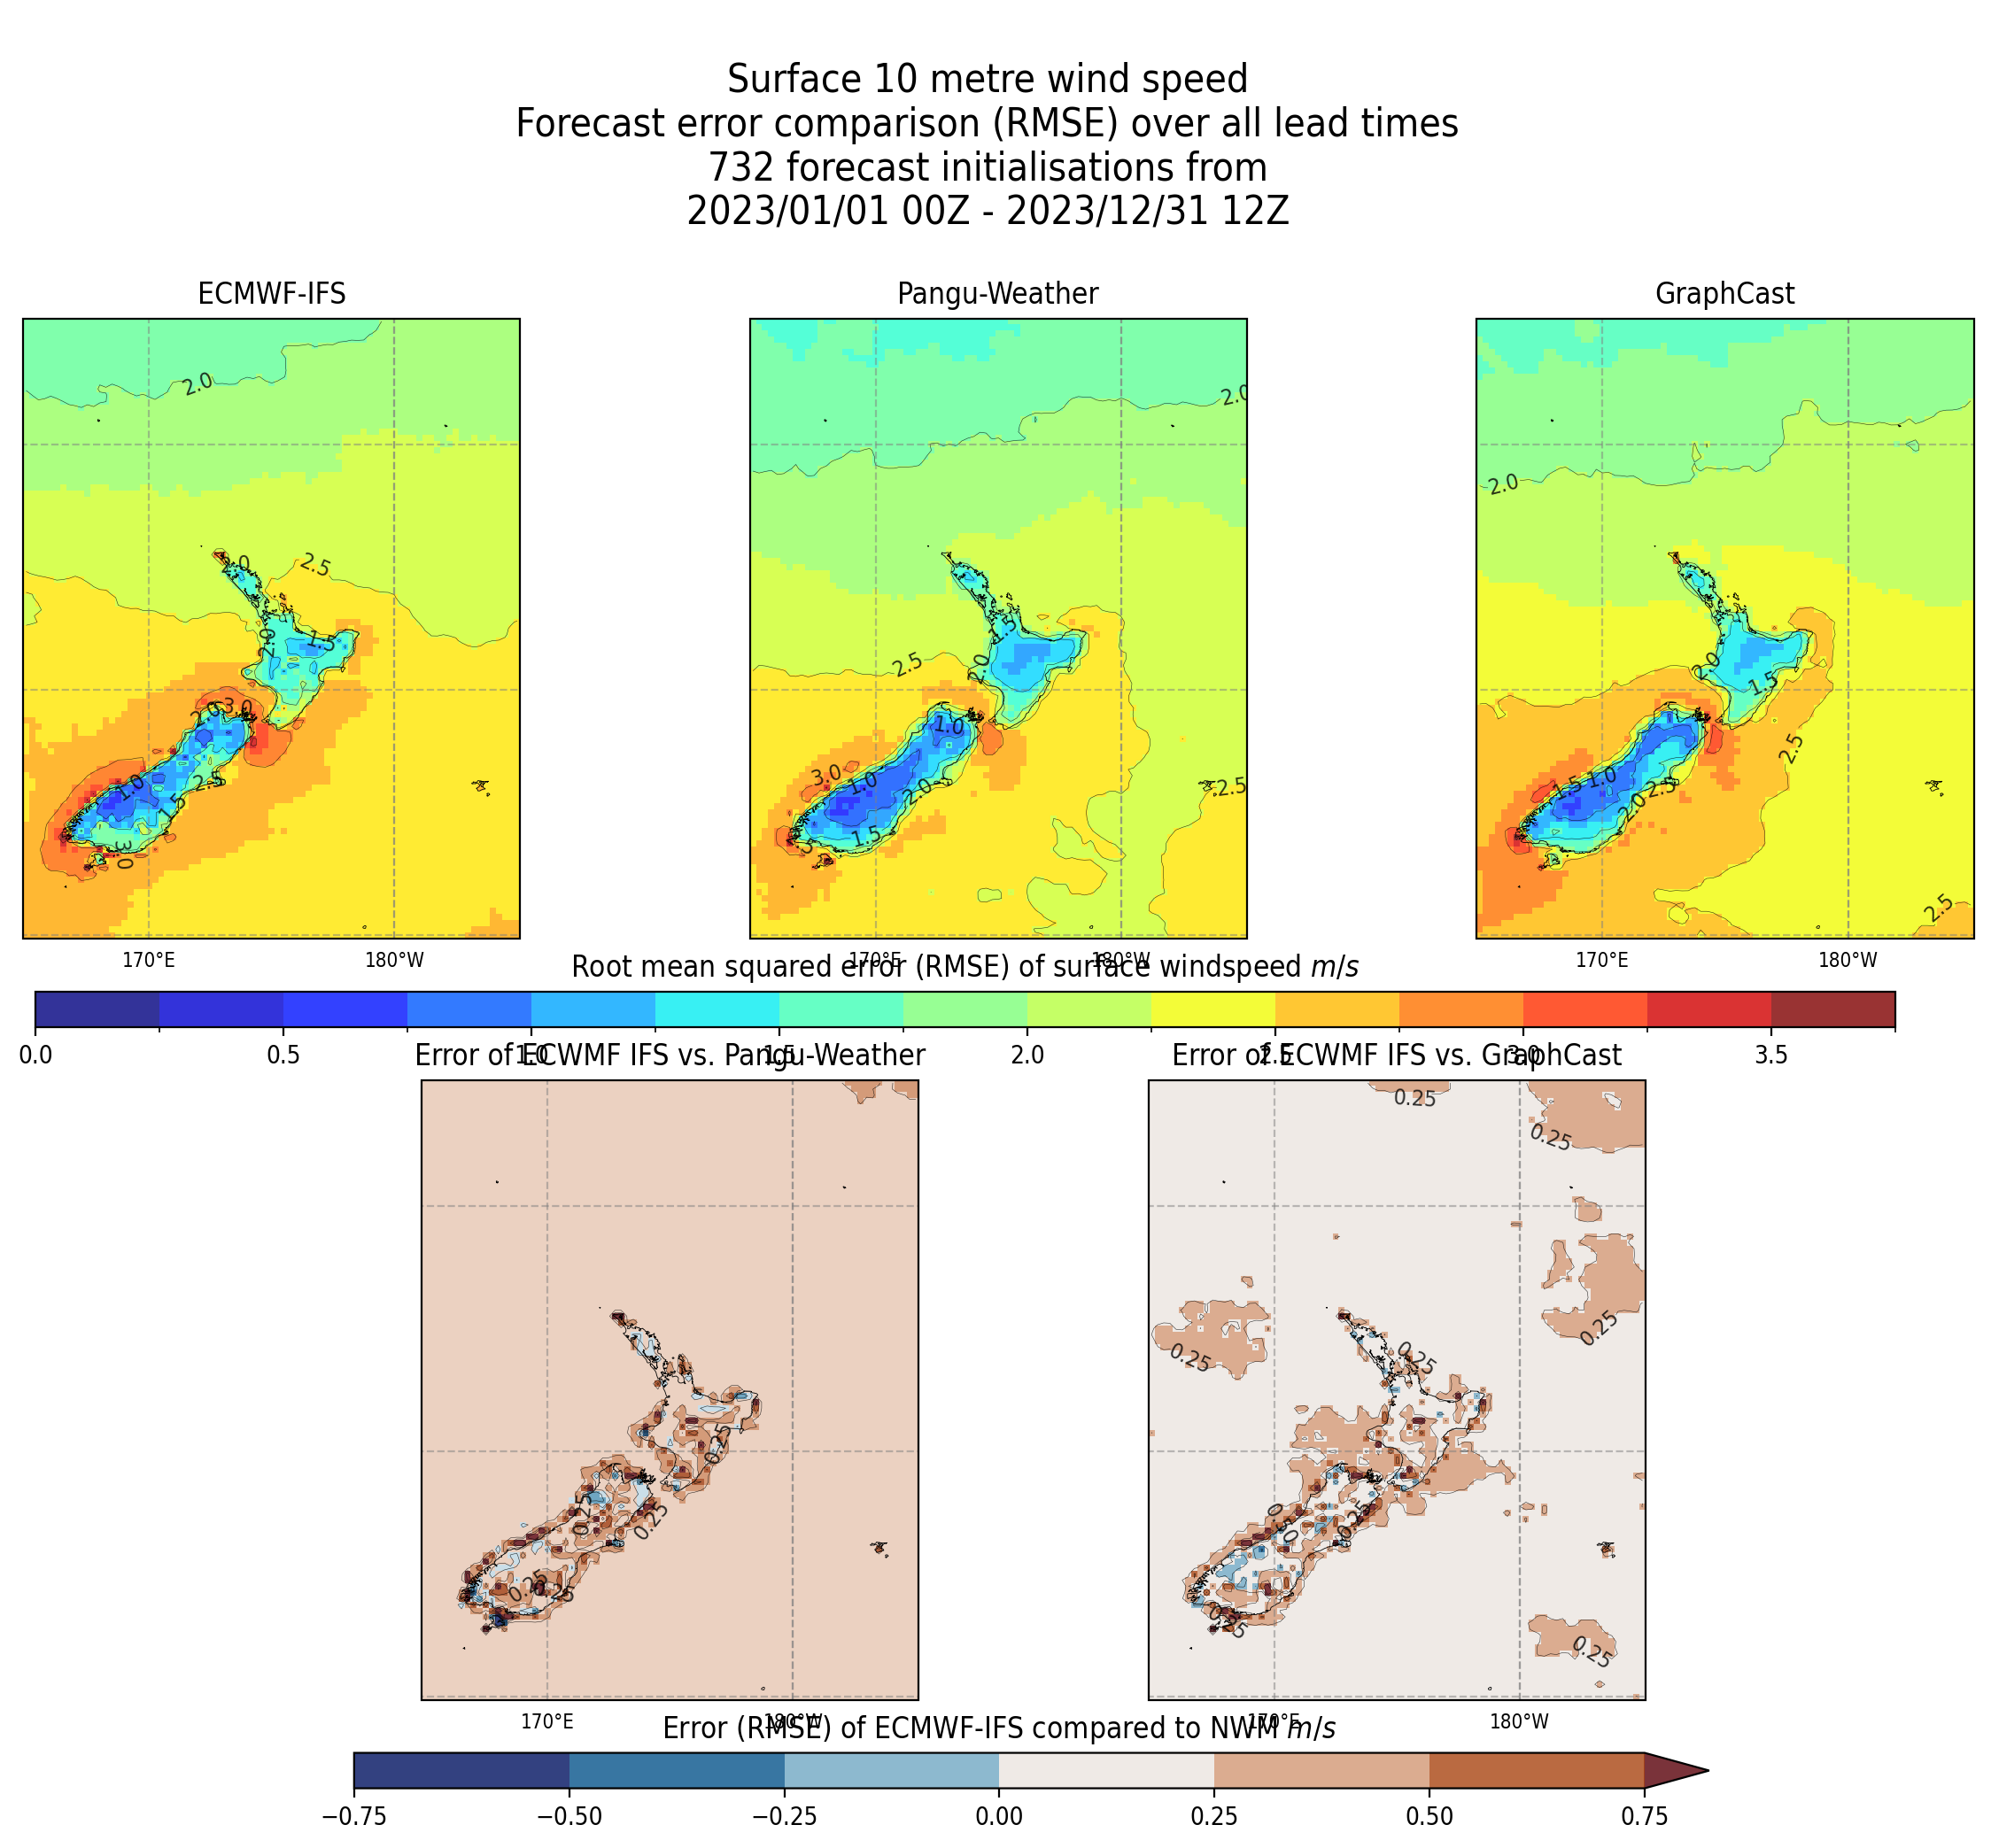

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=171)})

# Remove the last plot on the second row since we only need two plots there
fig.delaxes(axes[1, 2])
# Plot the first row (three plots)
datasets_row1 = [subset_ifs, subset_pgw, subset_gcs]
for i, (ax, ds) in enumerate(zip(axes[0, :], datasets_row1)):
    if ds is not None:
        r1 = ds[variable].plot(ax=ax,**plot_kw_abs)
        CS = ds[variable].isel(region = 0).plot.contour(
             ax=ax, **contour_kwargs_abs
        )
        ax.clabel(CS, CS.levels, inline=True, fontsize=9)

        
    ax.coastlines('10m',linewidth = 0.3)
    ax.set_title(f"Plot {i + 1}")  # Adjust the titles as necessary

# Plot the second row (two plots)
datasets_row2 = [diff_pgw, diff_gcs]
for i, (ax, ds) in enumerate(zip(axes[1, :], datasets_row2)):
    if ds is not None:
        r2 = ds[variable].plot(ax=ax, **plot_kw_diff)
        CS = ds[variable].isel(region = 0).plot.contour(
             ax=ax, **contour_kwargs_diff
        )
        ax.clabel(CS, CS.levels, inline=True, fontsize=9)

    ax.coastlines('10m', linewidth = 0.3)
    ax.set_title(f"Plot {i + 4}")  # Adjust the titles as necessary
    
    
pos1 = axes[1,0].get_position()
pos2 = axes[1,1].get_position()
offset = 0.15
# Move ax2 to the right by adjusting the x0 and x1 values
axes[1,0].set_position([pos1.x0 + offset, pos1.y0-0.01, pos1.width, pos1.height])
# Move ax2 to the right by adjusting the x0 and x1 values
axes[1,1].set_position([pos2.x0 + offset, pos2.y0-0.01, pos2.width, pos2.height])

    
    # First row colorbar
cbar_ax1 = fig.add_axes([0.15, 0.48, 0.7, 0.02])  # Adjust as necessary
fig.colorbar(r1, cax=cbar_ax1, orientation='horizontal')
cbar_ax1.set_title('Root mean squared error (RMSE) of surface windspeed $m/s$')

# Second row colorbar
cbar_ax2 = fig.add_axes([0.27, 0.05, 0.51, 0.02])  # Adjust as necessary
fig.colorbar(r2, cax=cbar_ax2, orientation='horizontal')
cbar_ax2.set_title('Error (RMSE) of ECMWF-IFS compared to NWM $m/s$')

# # Add a suptitle
plt.suptitle(
    f'''
    Surface 10 metre wind speed
    Forecast error comparison (RMSE) over all lead times
    732 forecast initialisations from
    2023/01/01 00Z - 2023/12/31 12Z
    ''',
    # ha = 'left',
    # x = 0.1,
    y = 1.05,
    fontsize=16
    )

axes[0,0].set_title('ECMWF-IFS')
axes[0,1].set_title('Pangu-Weather')
axes[0,2].set_title('GraphCast')
axes[1,0].set_title('Error of ECWMF IFS vs. Pangu-Weather')
axes[1,1].set_title('Error of ECWMF IFS vs. GraphCast')

for x in axes.flatten():
    set_gridlines(x)
fig.savefig(f'spatial_error_{variable}.png', bbox_inches = 'tight')


In [11]:
error_ifs_lt = subset_space(error_ifs).assign_coords({'lead_time' : error_ifs.lead_time.values/np.timedelta64(1, 'D') +.25 })
error_pgw_lt = subset_space(error_pgw).assign_coords({'lead_time' : error_pgw.lead_time.values/np.timedelta64(1, 'D')})
error_gcs_lt = subset_space(error_gcs).assign_coords({'lead_time' : error_gcs.lead_time.values/np.timedelta64(1, 'D')})
error_pgw_lt = error_pgw_lt.dropna('lead_time').interp_like(error_gcs_lt)


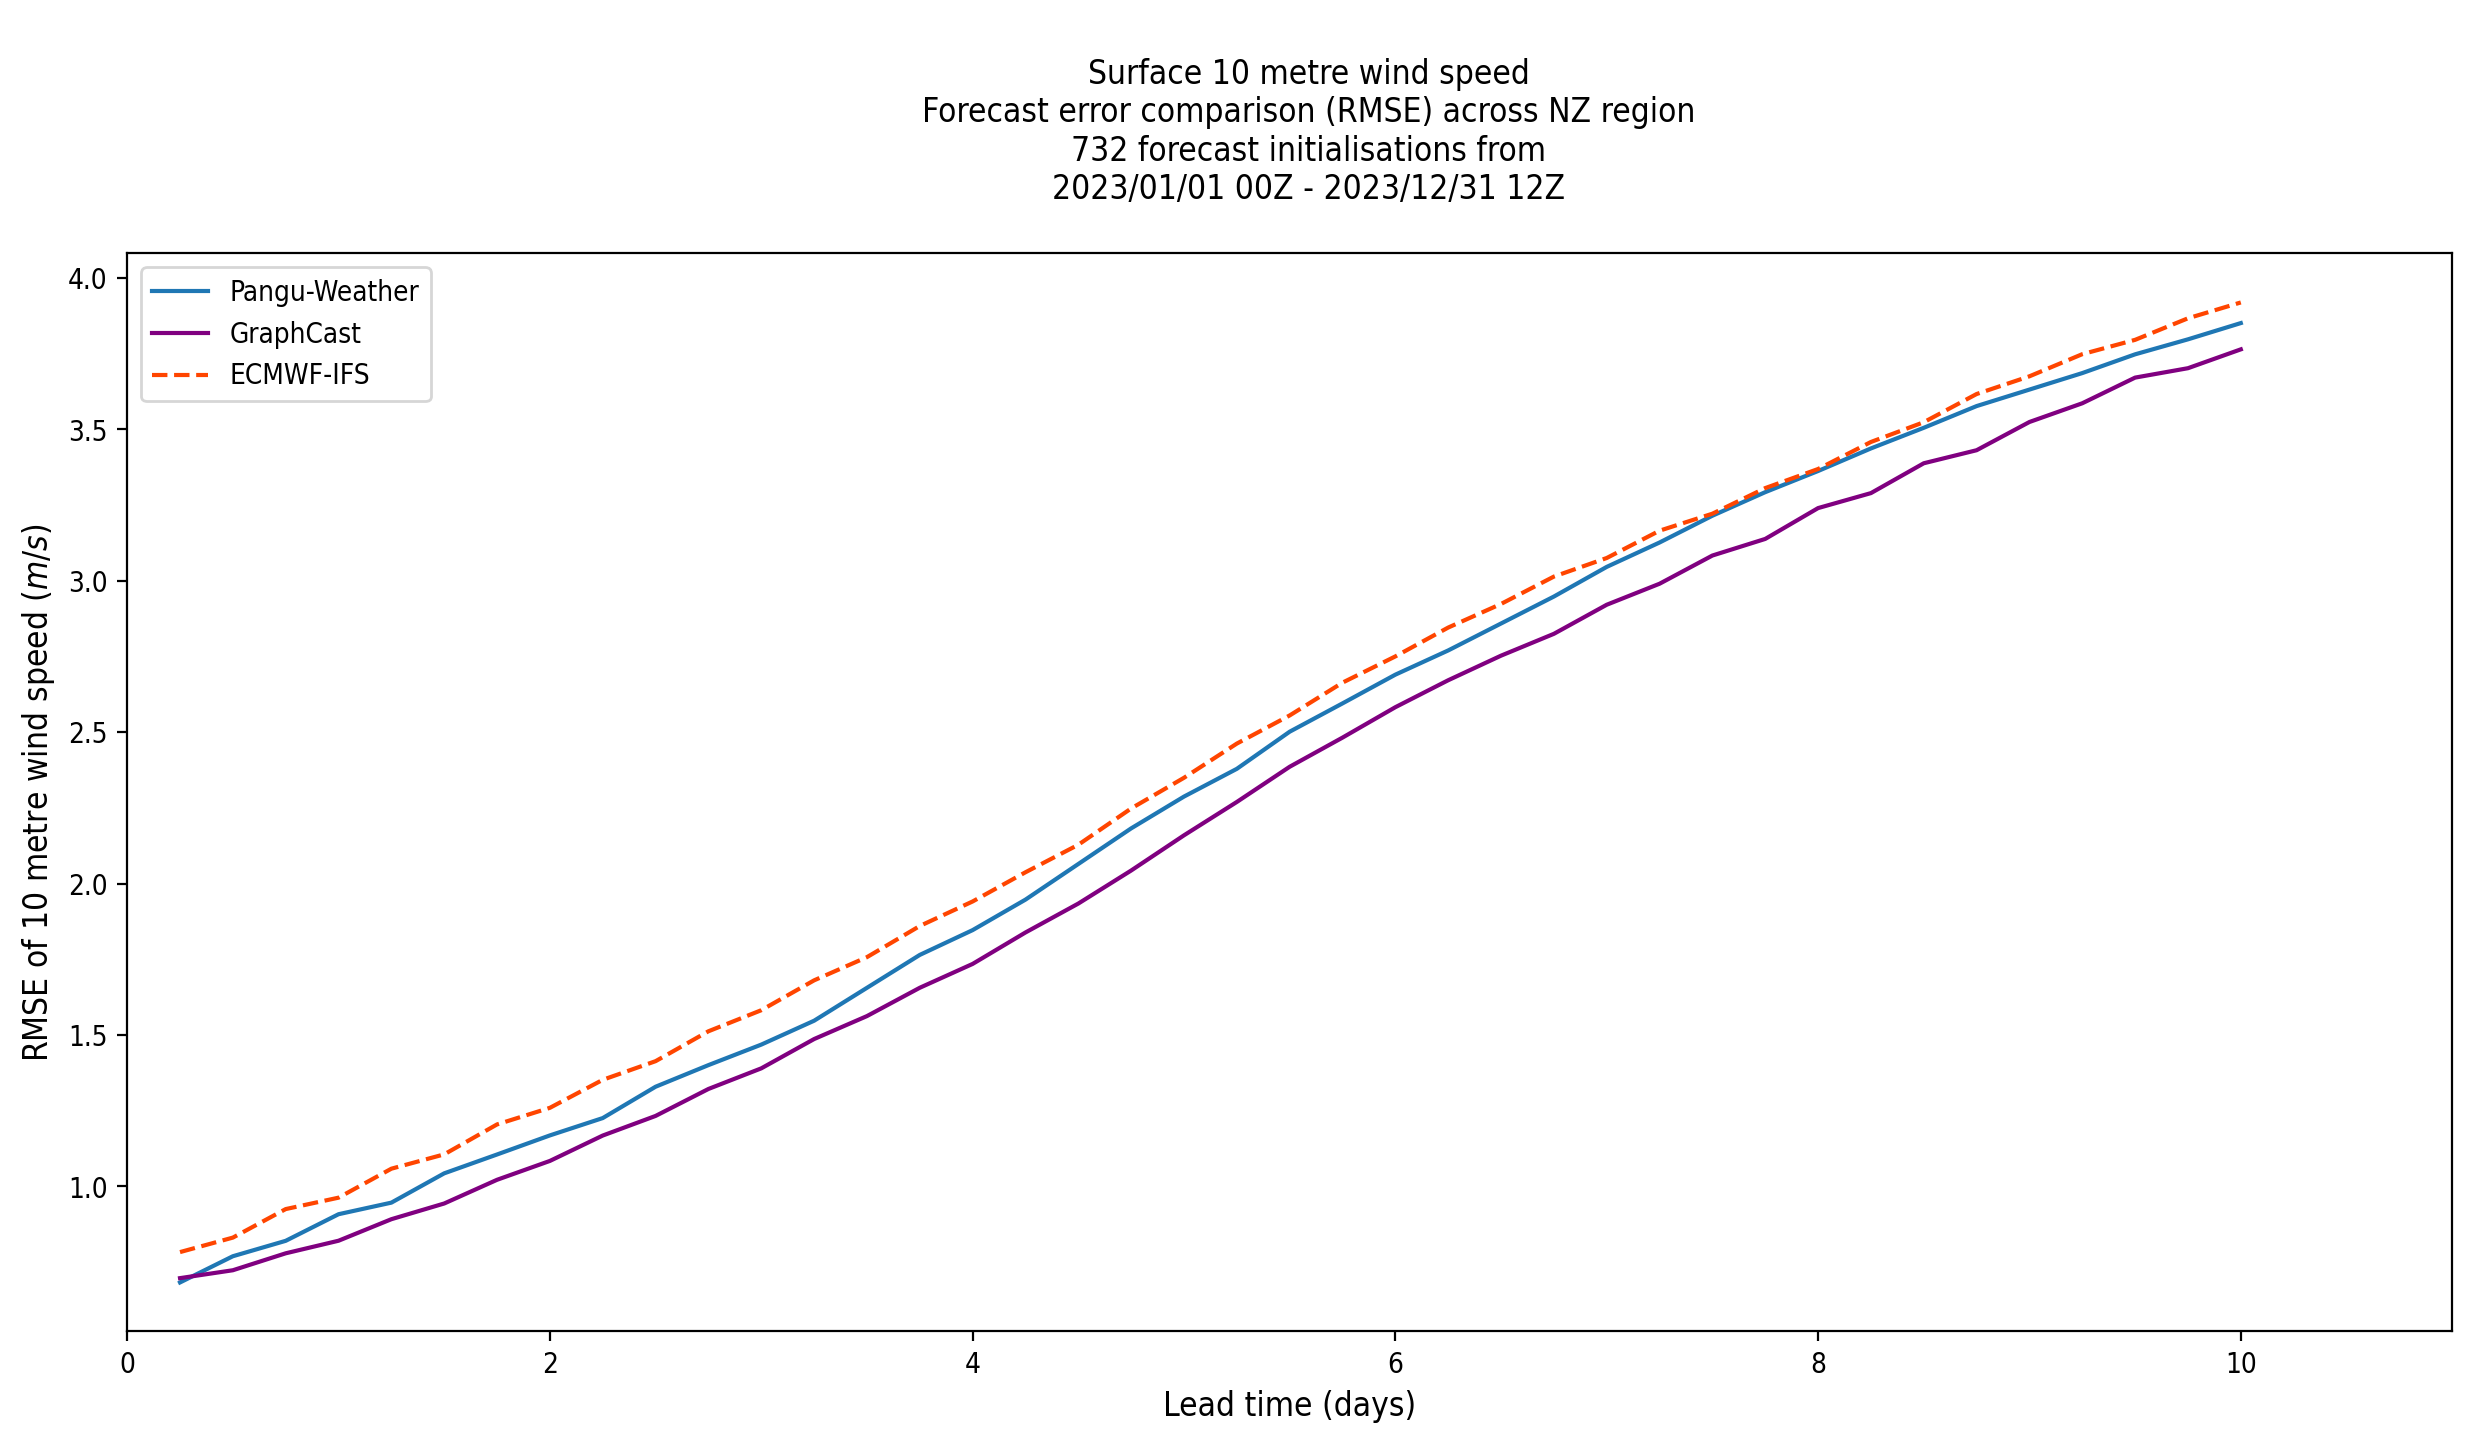

In [12]:
fig, ax = plt.subplots(1,1, figsize = (15,7))


error_pgw_lt[variable].plot(
    ax = ax,
    label = 'Pangu-Weather'
)
error_gcs_lt[variable].plot(
    ax = ax,
    label = 'GraphCast',
    
    color = 'purple'
)

error_ifs_lt[variable].isel(lead_time = slice(None, -1)).plot(
    ax = ax,
    label = 'ECMWF-IFS',
    color = 'orangered',
    linestyle = '--'
)


ax.legend()
# ax.grid()
ax.set_xlim([0, 11])

ax.set_xlabel('Lead time (days)', fontsize = 12)
ax.set_ylabel('RMSE of 10 metre wind speed ($m/s$)', fontsize = 12)

ax.set_title(
    f'''
    Surface 10 metre wind speed
    Forecast error comparison (RMSE) across NZ region
    732 forecast initialisations from
    2023/01/01 00Z - 2023/12/31 12Z
    '''
    )

fig.savefig(f'lead_time_error_{variable}.png', bbox_inches = 'tight')

# Mea Sea Level Pressure

In [48]:
variable = 'mean_sea_level_pressure'
plot_kw_abs, contour_kw_abs = create_plot_kwargs(cmap = 'jet', vmin = 0, vmax = 6, spacing = 1)
plot_kw_diff, contour_kw_diff = create_plot_kwargs(cmap = 'vik', vmin = -1.5, vmax = 1.5, spacing = 0.25)

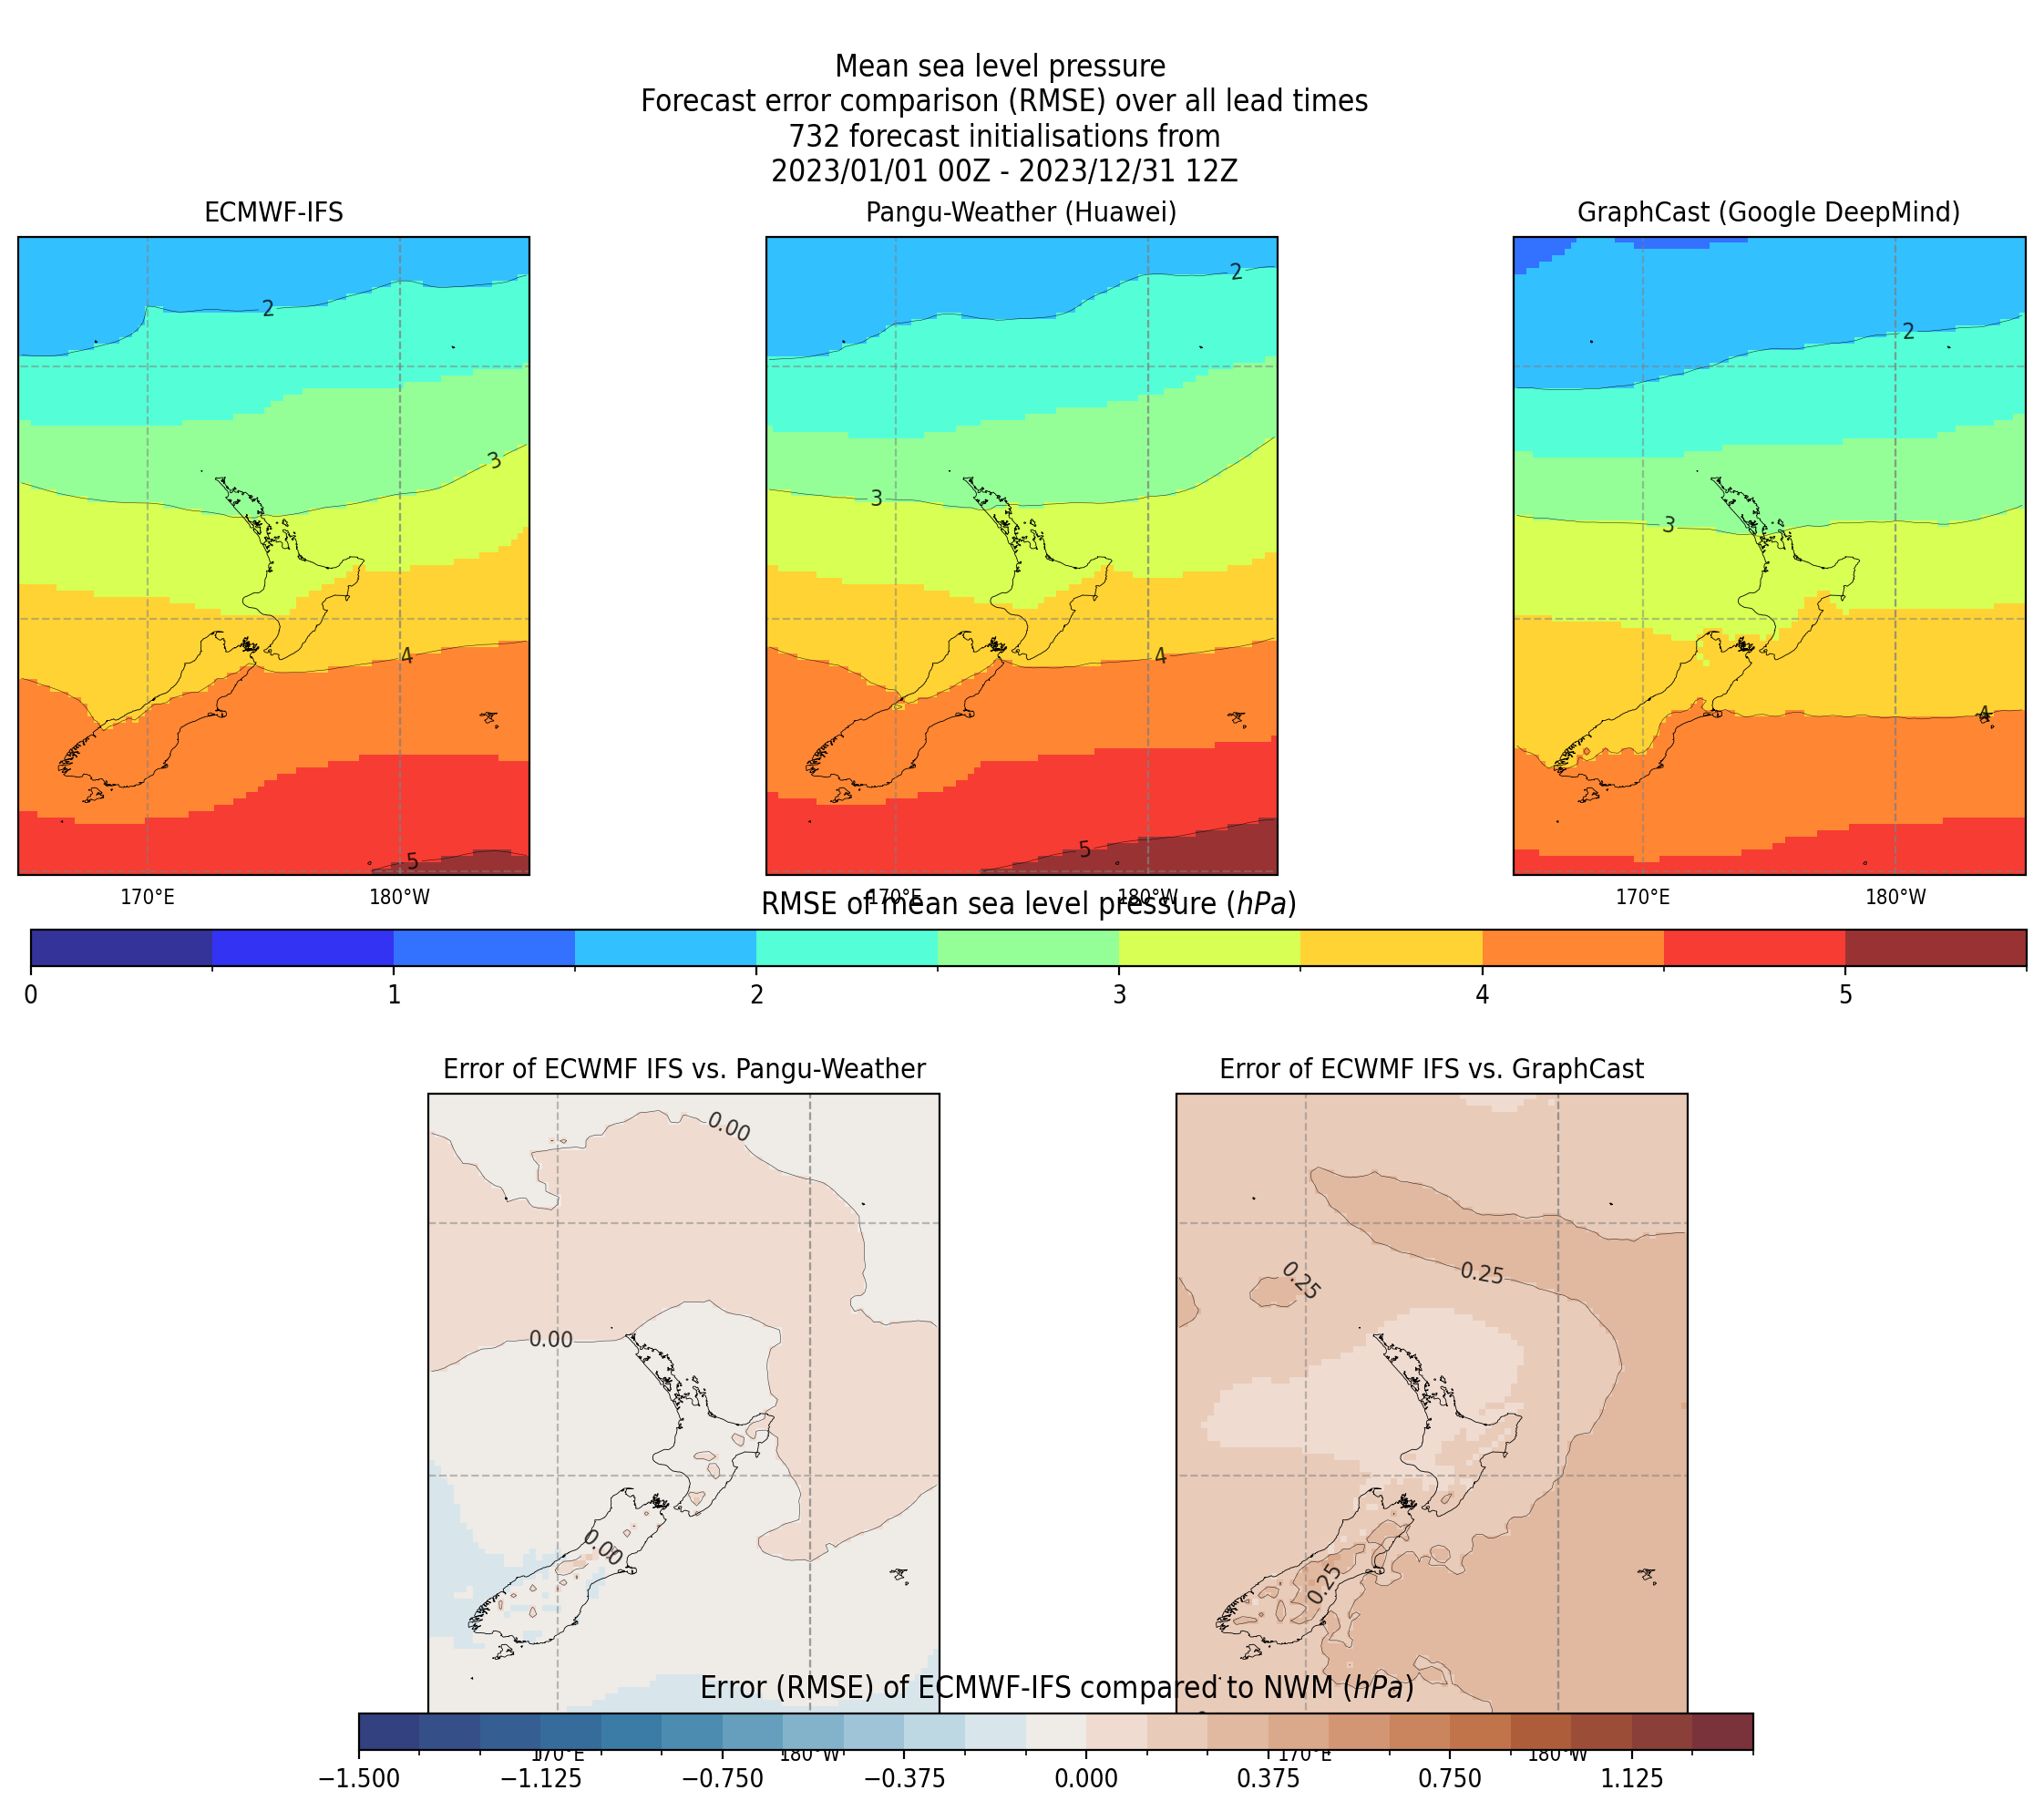

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=171)})

# Remove the last plot on the second row since we only need two plots there
fig.delaxes(axes[1, 2])
# Plot the first row (three plots)
datasets_row1 = [subset_ifs, subset_pgw, subset_gcs]
for i, (ax, ds) in enumerate(zip(axes[0, :], datasets_row1)):
    if ds is not None:
        r1 = (ds[variable]/100).plot(ax=ax,**plot_kw_abs)
        CS = (ds[variable]/100).isel(region = 0).plot.contour(
             ax=ax, **contour_kw_abs
        )
        ax.clabel(CS, CS.levels, inline=True, fontsize=9)

        
    ax.coastlines('10m',linewidth = 0.3)
    ax.set_title(f"Plot {i + 1}")  # Adjust the titles as necessary

# Plot the second row (two plots)
datasets_row2 = [diff_pgw, diff_gcs]
for i, (ax, ds) in enumerate(zip(axes[1, :], datasets_row2)):
    if ds is not None:
        r2 = (ds[variable]/100).plot(ax=ax, **plot_kw_diff)
        CS = (ds[variable]/100).isel(region = 0).plot.contour(
             ax=ax, **contour_kw_diff
        )
        ax.clabel(CS, CS.levels, inline=True, fontsize=9)

    ax.coastlines('10m', linewidth = 0.3)
    ax.set_title(f"Plot {i + 4}")  # Adjust the titles as necessary
    
    
pos1 = axes[1,0].get_position()
pos2 = axes[1,1].get_position()
offset = 0.15
# Move ax2 to the right by adjusting the x0 and x1 values
axes[1,0].set_position([pos1.x0 + offset, pos1.y0-0.05, pos1.width, pos1.height])
# Move ax2 to the right by adjusting the x0 and x1 values
axes[1,1].set_position([pos2.x0 + offset, pos2.y0-0.05, pos2.width, pos2.height])

    
    # First row colorbar
cbar_ax1 = fig.add_axes([0.15, 0.48, 0.73, 0.02])  # Adjust as necessary
fig.colorbar(r1, cax=cbar_ax1, orientation='horizontal')
cbar_ax1.set_title('RMSE of mean sea level pressure ($hPa$)')

# Second row colorbar
cbar_ax2 = fig.add_axes([0.27, 0.05, 0.51, 0.02])  # Adjust as necessary
fig.colorbar(r2, cax=cbar_ax2, orientation='horizontal')
cbar_ax2.set_title('Error (RMSE) of ECMWF-IFS compared to NWM ($hPa$)')

# # Add a suptitle
plt.suptitle(
    f'''
    Mean sea level pressure 
    Forecast error comparison (RMSE) over all lead times
    732 forecast initialisations from
    2023/01/01 00Z - 2023/12/31 12Z
    ''',
    # ha = 'left',
    # x = 0.1,
    y = 1.0,
    fontsize=12
    )

axes[0,0].set_title('ECMWF-IFS', fontsize = 11)
axes[0,1].set_title('Pangu-Weather', fontsize = 11)
axes[0,2].set_title('GraphCast', fontsize = 11)
axes[1,0].set_title('Error of ECWMF IFS vs. Pangu-Weather', fontsize = 11)
axes[1,1].set_title('Error of ECWMF IFS vs. GraphCast', fontsize = 11)

for x in axes.flatten():
    set_gridlines(x)
fig.savefig(f'spatial_error_{variable}.png', bbox_inches = 'tight')


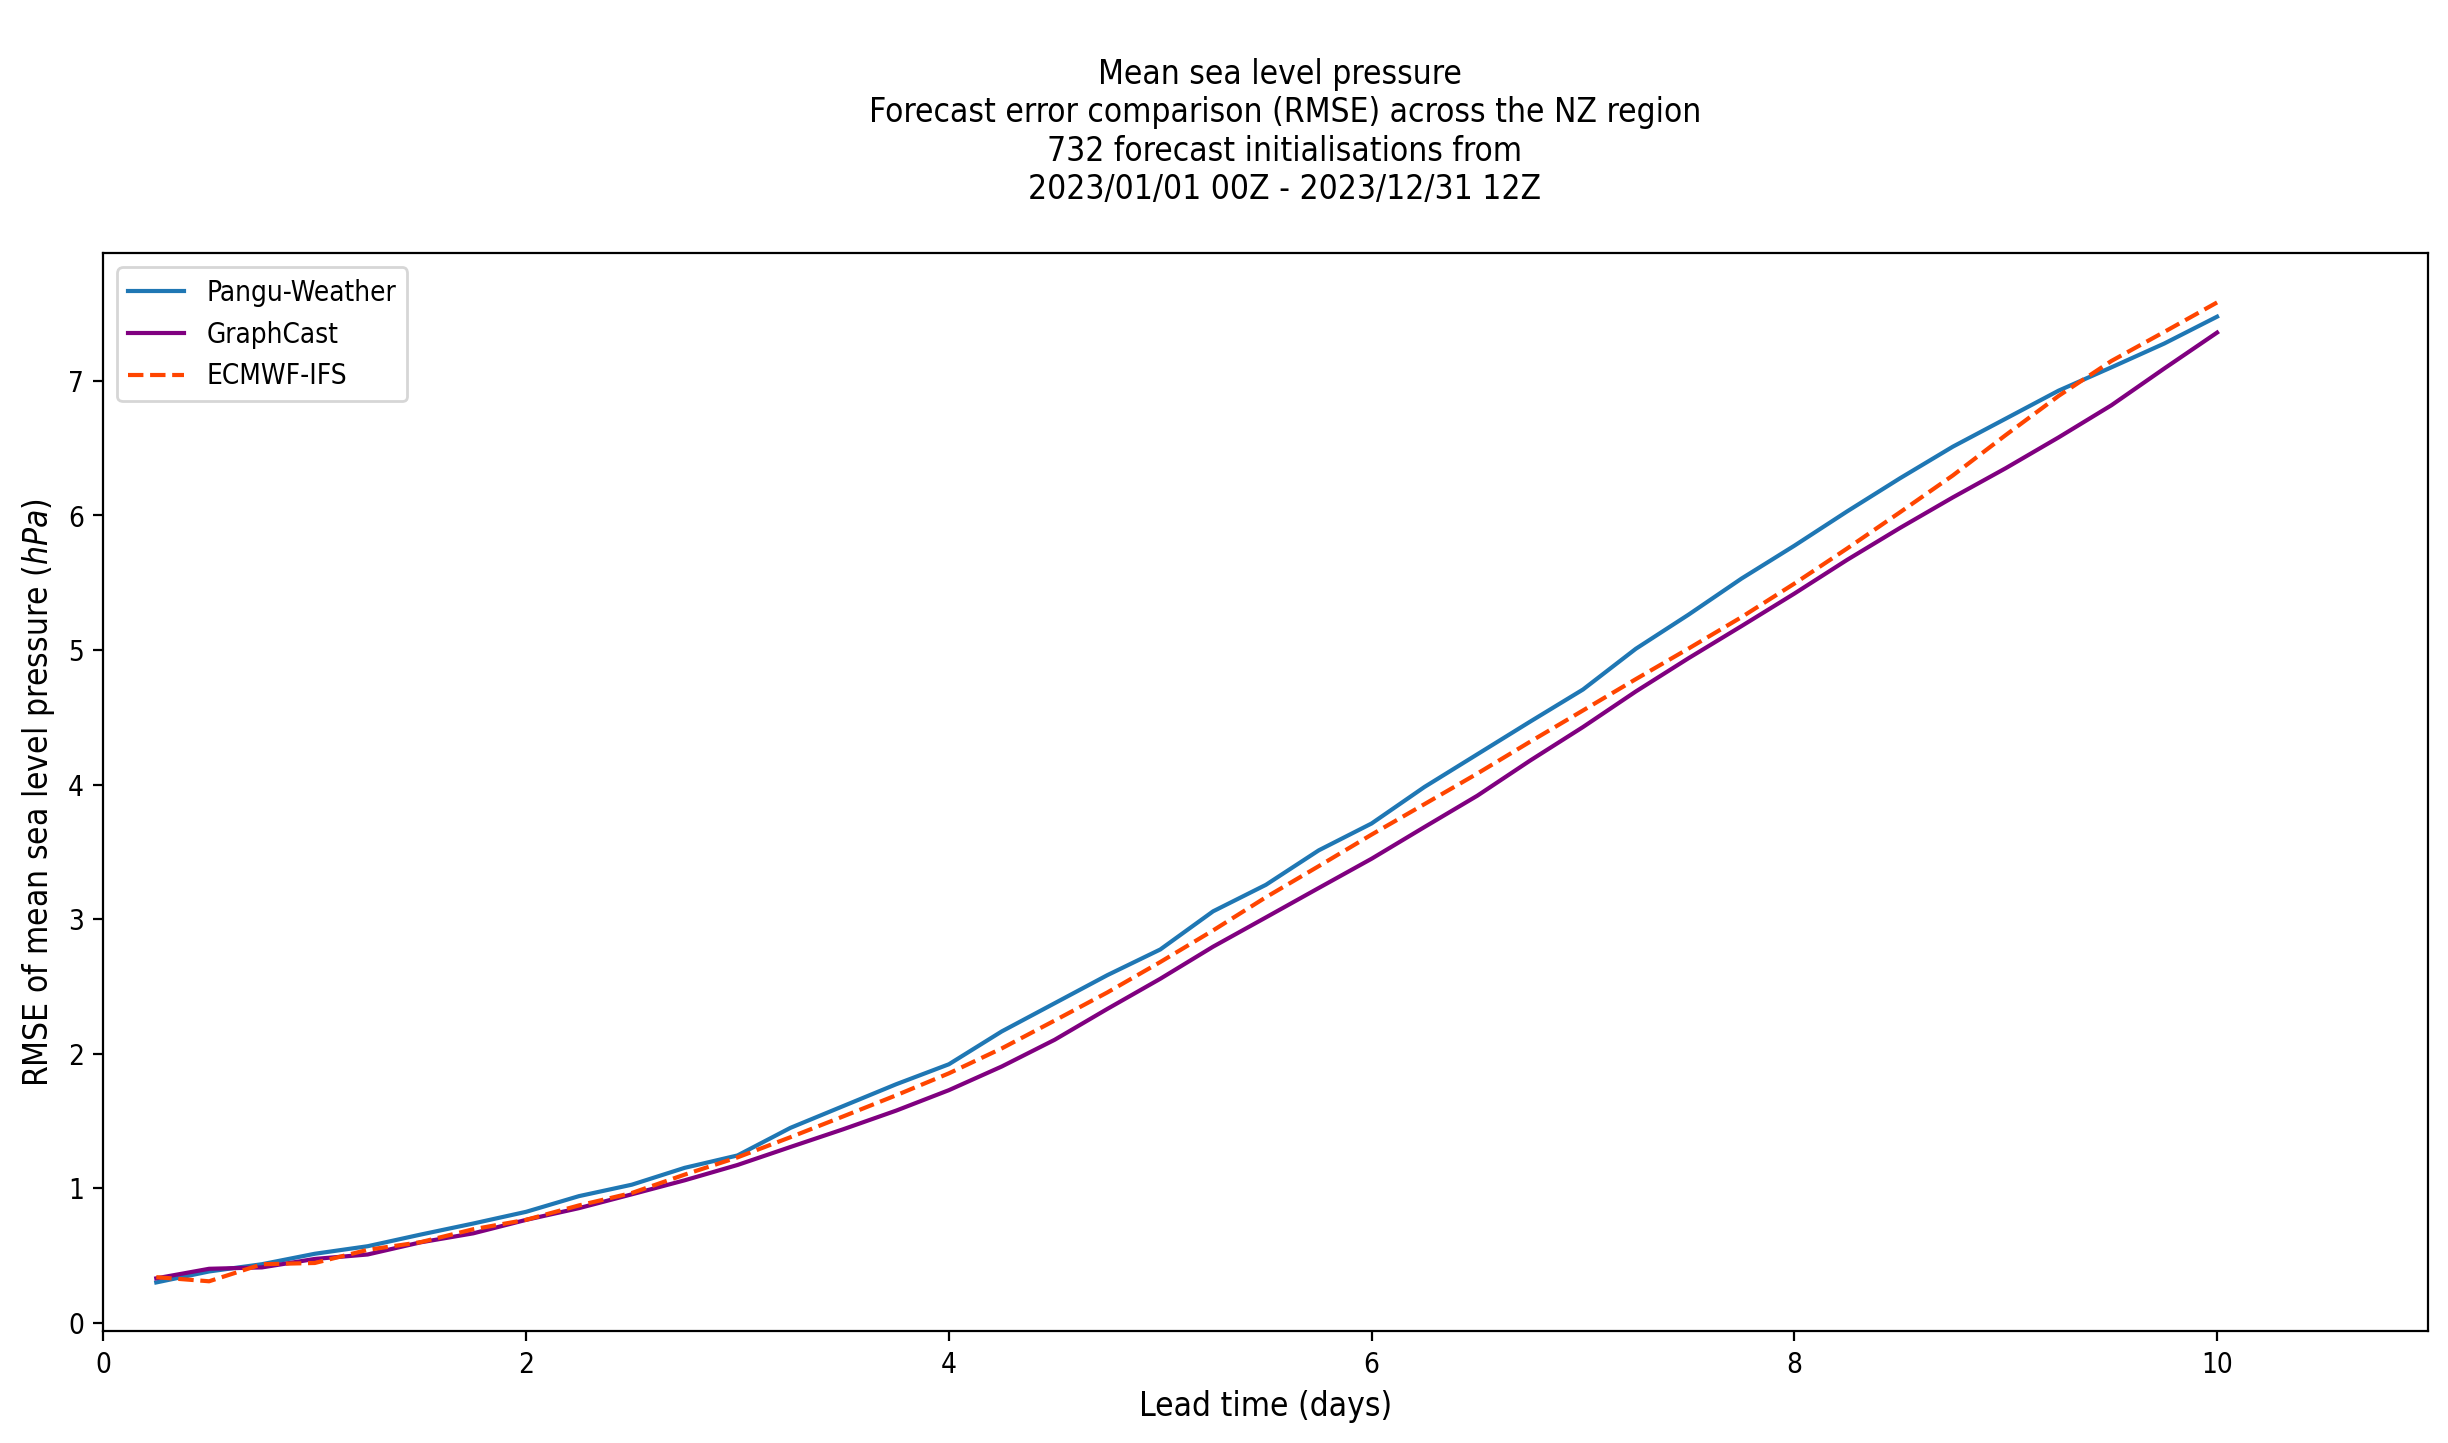

In [16]:
fig, ax = plt.subplots(1,1, figsize = (15,7))


(error_pgw_lt[variable]/100).plot(
    ax = ax,
    label = 'Pangu-Weather'
)
(error_gcs_lt[variable]/100).plot(
    ax = ax,
    label = 'GraphCast',
    
    color = 'purple'
)

(error_ifs_lt[variable]/100).isel(lead_time = slice(None, -1)).plot(
    ax = ax,
    label = 'ECMWF-IFS',
    color = 'orangered',
    linestyle = '--'
)


ax.legend()
# ax.grid()
ax.set_xlim([0, 11])

ax.set_xlabel('Lead time (days)', fontsize = 12)
ax.set_ylabel('RMSE of mean sea level pressure ($hPa$)', fontsize = 12)

ax.set_title(
    f'''
    Mean sea level pressure 
    Forecast error comparison (RMSE) across the NZ region
    732 forecast initialisations from
    2023/01/01 00Z - 2023/12/31 12Z
    '''
    )

fig.savefig(f'lead_time_error_{variable}.png', bbox_inches = 'tight')